In [1]:
#Define functions to extract features from images and test a method
#Always run this first cell for all the imports and global variable definitions
#To be run in the workenvAutoencoder2 environment

from skimage.feature import graycomatrix, graycoprops
import numpy as np
from tqdm import tqdm
import os

import pywt
from skimage.io import imread
from skimage.color import rgb2gray

from skimage.feature import local_binary_pattern
from skimage.util import img_as_ubyte
from skimage.transform import radon
from scipy.ndimage import gaussian_filter
from scipy.ndimage import generic_filter
from scipy.stats import kurtosis, skew
import nibabel as nib
import SimpleITK as sitk
import mahotas as mh
import tifffile as tif
import xgboost as xgb

from radiomics import featureextractor

MAIN_DIR = 'E:/AAV para enfermedades renales/LSFM combined images/TextureAnalysis/Tiles3D/CenteredInGlom-prepared'


def normalize_image(image):
    # Normalize the image to the range [0, 1]
    image = image - np.min(image)
    image = image / np.max(image)
    return image


#Define several functions to extract features from an image
#-----------------------------------------------------------------------------------------

#General Features
def calculate_statistical_features(image):
    mean_val = np.mean(image)
    variance_val = np.var(image)
    skewness_val = skew(image,axis=None)
    kurtosis_val = kurtosis(image,axis=None)
    #hist, _ = np.histogram(image, bins=256, range=(0, 255))
    #hist = hist / np.sum(hist)
    #entropy_val = -np.sum(hist * np.log2(hist + np.finfo(float).eps))
    return mean_val, variance_val, skewness_val, kurtosis_val
    
#Wavelet features in 3D
def calculate_wavelet_features3D(image):
    # Perform 3D discrete wavelet transform
    coeffs = pywt.dwtn(image, 'db1')
    
    # Extract approximation and detail coefficients
    cA = coeffs['aaa']
    cH = coeffs['daa']
    cV = coeffs['ada']
    cD = coeffs['aad']
    
    # Compute the mean of the coefficients
    approx_coeff_mean = np.mean(cA)
    horiz_coeff_mean = np.mean(cH)
    vert_coeff_mean = np.mean(cV)
    depth_coeff_mean = np.mean(cD)

    return approx_coeff_mean, horiz_coeff_mean, vert_coeff_mean, depth_coeff_mean

    
#Fourier features in 3D
def calculate_fourier_features_3d(image):
    # Perform 3D Fast Fourier Transform
    fft_image = np.fft.fftn(image)
    fft_magnitude = np.abs(fft_image)

    # Find the dominant frequency
    dominant_frequency_magnitude = np.max(fft_magnitude)
    
    # Calculate the total energy
    total_energy = np.sum(fft_magnitude ** 2)

    return dominant_frequency_magnitude, total_energy
    
#Local Binary Patterns (LBP) uniformity in 3D
def lbp_code_3d(neighborhood):
    center = neighborhood[len(neighborhood) // 2]
    binary_pattern = (neighborhood >= center).astype(int)
    binary_pattern = np.delete(binary_pattern, len(binary_pattern) // 2)  # Remove the center pixel
    lbp_value = np.dot(binary_pattern, 1 << np.arange(binary_pattern.size)[::-1])
    return lbp_value

def calculate_lbp_uniformity_3d(image, radius=1):
    # Define the neighborhood shape for 3D LBP
    neighborhood_shape = (2 * radius + 1, 2 * radius + 1, 2 * radius + 1)
    
    # Apply the 3D LBP calculation
    lbp_image = generic_filter(image, lbp_code_3d, size=neighborhood_shape, mode='constant', cval=0)
    
    # Compute the histogram of LBP values
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 2**(neighborhood_shape[0]**3 - 1) + 1), range=(0, 2**(neighborhood_shape[0]**3 - 1)))
    lbp_hist = lbp_hist / np.sum(lbp_hist)  # Normalize histogram
    
    # Calculate uniformity measure
    lbp_uniformity = np.sum(lbp_hist**2)

    return lbp_uniformity


def calculate_porosity(image):
    threshold = np.mean(image)  # Use mean intensity as a threshold
    hole_area = np.sum(image < threshold)  # Count low-intensity pixels (holes)
    total_area = image.size  # Total number of pixels
    porosity = hole_area / total_area
    return porosity
#-----------------------------------------------------------------------------------------

#Define a function to extract all features from a set of images and produce a numpy array
def extract_features(MAIN_DIR,setName):
    # Define GLCM parameters
    featureNames = 'mean_val', 'variance_val', 'skewness_val', 'kurtosis_val',\
    'approx_coeff_mean', 'horiz_coeff_mean', 'vert_coeff_mean', 'depth_coeff_mean',\
    'dominant_frequency_magnitude', 'total_energy',\
    'lbp_uniformity',\
    'porosity'
    
    initDir = os.getcwd()

    os.chdir(MAIN_DIR)

    #Entry 0 to store the Healthy features, entry 1 to store the Pathological features
    data = [[], []]

    print(f'Processing images from the {setName} set:')

    for stateName in os.listdir(f'{setName}'):
        #For the Healthy and Pathological folders
        if stateName == 'Healthy':
            stateNum = 0
            
        elif stateName == 'Pathological':
            stateNum = 1
            
        print(f'{stateName} images')

        for imName in tqdm(os.listdir(f'{setName}/{stateName}')):
                
            # Load and normalize the image
            image = tif.imread(f'{setName}/{stateName}/{imName}')
            image = normalize_image(image)

            # Statistical features
            mean_val, variance_val, skewness_val, kurtosis_val = calculate_statistical_features(image)         
            
            # Wavelet features
            approx_coeff_mean, horiz_coeff_mean, vert_coeff_mean, depth_coeff_mean = calculate_wavelet_features3D(image)

            # Fourier features
            dominant_frequency_magnitude, total_energy = calculate_fourier_features_3d(image)

            # Average diameter of circles with radon transform
            #average_diameter_radon,average_radial_intensity_radon = measure_average_diameter_radon(image)

            #LBP uniformity
            lbp_uniformity = calculate_lbp_uniformity_3d(image)

            #Porosity
            porosity = calculate_porosity(image)

            features = np.array([mean_val, variance_val, skewness_val, kurtosis_val,  
                                 approx_coeff_mean, horiz_coeff_mean, vert_coeff_mean, depth_coeff_mean,
                                 dominant_frequency_magnitude, total_energy, 
                                 lbp_uniformity,
                                 porosity])
            
            #Save the features in the corresponding list
            data[stateNum].append(features)

    healthyFeatures = np.vstack(data[0])
    pathologicalFeatures = np.vstack(data[1])

    healthyLabels = np.zeros(healthyFeatures.shape[0],dtype=int)
    pathologicalLabels = np.ones(pathologicalFeatures.shape[0],dtype=int)

    allFeatures = np.vstack([healthyFeatures, pathologicalFeatures])
    allLabels = np.hstack([healthyLabels, pathologicalLabels])

    os.chdir(initDir)
    return allFeatures, allLabels, featureNames

def get_test_results(method,testData,testLabels,dataTuple = False):
    #Test a method and print the results

    if dataTuple is True:
        #The dataformat is a tuple with the features and the labels
        testData = xgb.DMatrix(testData, label=testLabels)

    #Positives will be the Pathological images
    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0

    predictions = method.predict(testData)

    #If the predictions are not a binary vector
    if not np.all(np.isin(predictions, [0, 1])):
        #Threshold them to make them binary
        predictions = np.where(predictions >= 0.5, 1, 0)

    print('predictions')
    print(predictions)

    print('ground truth labels')
    print(testLabels)
    
    for i in range(len(predictions)):
        if predictions[i] == testLabels[i] and testLabels[i] == 1:
            truePos += 1
        elif predictions[i] == testLabels[i] and testLabels[i] == 0:
            trueNeg += 1
        elif predictions[i] != testLabels[i] and testLabels[i] == 0:
            falsePos += 1
        elif predictions[i] != testLabels[i] and testLabels[i] == 1:
            falseNeg += 1
        #print(f'Predicted: {predictions[i]}, True: {test_labels[i]}')

    print(f'Total predictions: {len(predictions)}')
    print(f'True positives: {truePos}')
    print(f'True negatives: {trueNeg}')
    print(f'False positives: {falsePos}')
    print(f'False negatives: {falseNeg}')
    print(f'Accuracy: {(truePos+trueNeg)/len(predictions)}')
    print(f'Sensitivity: {truePos/(truePos+falseNeg)}')
    print(f'Specificity: {trueNeg/(trueNeg+falsePos)}')
    print(f'f1-score: {2*truePos/(2*truePos+falsePos+falseNeg)}')


In [2]:
testData,testLabels,featureNames = extract_features(MAIN_DIR,'test')
header = ','.join(featureNames)
np.savetxt('testData.txt', testData, delimiter=',', header=header, comments='')
np.savetxt('testLabels.txt', testLabels, delimiter=',', header='Label', comments='')

valData,valLabels,featureNames = extract_features(MAIN_DIR,'validation')
header = ','.join(featureNames)
np.savetxt('valData.txt', valData, delimiter=',', header=header, comments='')
np.savetxt('valLabels.txt', valLabels, delimiter=',', header='Label', comments='', fmt='%d')

trainData,trainLabels,featureNames = extract_features(MAIN_DIR,'train')
header = ','.join(featureNames)
np.savetxt('trainData.txt', trainData, delimiter=',', header=header, comments='')
np.savetxt('trainLabels.txt', trainLabels, delimiter=',', header='Label', comments='', fmt='%d')

Processing images from the test set:
Healthy images


  0%|          | 0/40 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  2%|▎         | 1/40 [01:48<1:10:13, 108.05s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  5%|▌         | 2/40 [03:33<1:07:34, 106.70s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  8%|▊         | 3/40 [05:17<1:05:02, 105.48s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
 10%|█         | 4/40 [07:00<1:02:34, 104.29s/it]GLCM is symmet

Pathological images


  0%|          | 0/40 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  2%|▎         | 1/40 [01:38<1:04:13, 98.81s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  5%|▌         | 2/40 [03:17<1:02:33, 98.79s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  8%|▊         | 3/40 [04:55<1:00:43, 98.48s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
 10%|█         | 4/40 [06:34<59:14, 98.74s/it]  GLCM is symmetrica

Processing images from the validation set:
Healthy images


  0%|          | 0/40 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  2%|▎         | 1/40 [01:39<1:04:53, 99.83s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  5%|▌         | 2/40 [03:19<1:03:11, 99.77s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  8%|▊         | 3/40 [04:59<1:01:26, 99.63s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
 10%|█         | 4/40 [06:38<59:37, 99.38s/it]  GLCM is symmetrica

Pathological images


  0%|          | 0/40 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  2%|▎         | 1/40 [01:38<1:04:18, 98.92s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  5%|▌         | 2/40 [03:18<1:02:49, 99.19s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  8%|▊         | 3/40 [04:57<1:01:13, 99.29s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
 10%|█         | 4/40 [06:37<59:36, 99.35s/it]  GLCM is symmetrica

Processing images from the train set:
Healthy images


  0%|          | 0/237 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  0%|          | 1/237 [01:39<6:29:56, 99.14s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  1%|          | 2/237 [03:16<6:24:40, 98.21s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  1%|▏         | 3/237 [04:55<6:24:11, 98.51s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  2%|▏         | 4/237 [06:34<6:23:11, 98.68s/it]GLCM is symme

Pathological images


  0%|          | 0/80 [00:00<?, ?it/s]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  1%|▏         | 1/80 [01:39<2:10:32, 99.15s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  2%|▎         | 2/80 [03:18<2:08:59, 99.23s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  4%|▍         | 3/80 [04:57<2:07:23, 99.27s/it]GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
  5%|▌         | 4/80 [06:36<2:05:38, 99.20s/it]GLCM is symmetrica

In [2]:
#Read the data from the files to later apply a classifier


#First read the feature names
featureNames = np.genfromtxt('testData.txt', delimiter=',', max_rows=1, dtype=str)

#Then load the data
testData = np.loadtxt('testData.txt', delimiter=',', skiprows=1)
testLabels = np.loadtxt('testLabels.txt', delimiter=',', skiprows=1)

valData = np.loadtxt('valData.txt', delimiter=',', skiprows=1)
valLabels = np.loadtxt('valLabels.txt', delimiter=',', skiprows=1)

trainData = np.loadtxt('trainData.txt', delimiter=',', skiprows=1)
trainLabels = np.loadtxt('trainLabels.txt', delimiter=',', skiprows=1)

In [31]:
# Fit an XGBoost classifier and test it (with XGBClassifier), after performing hyperparameter grid search
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import pandas as pd
import json

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Combine train and validation data
combinedData = np.concatenate((trainData, valData), axis=0)
combinedLabels = np.concatenate((trainLabels, valLabels), axis=0)

# Create a validation fold index
test_fold = np.concatenate((
    np.full(trainData.shape[0], -1),  # -1 for training set
    np.zeros(valData.shape[0])        # 0 for validation set
))

# Create PredefinedSplit
ps = PredefinedSplit(test_fold)

# Initialize the model
model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    use_label_encoder=False,  
    tree_method='gpu_hist'  
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=ps,  # Use PredefinedSplit
    verbose=2,  # Set verbose to 2 for detailed progress information
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(combinedData, combinedLabels)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
# Save the best parameters to a text file
with open('best_params.txt', 'w') as file:
    json.dump(best_params, file)

Fitting 1 folds for each of 19683 candidates, totalling 19683 fits


c:\Users\equipo\.conda\envs\workenvAutoencoder2\lib\site-packages\xgboost\core.py:158: UserWarning: [18:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\equipo\.conda\envs\workenvAutoencoder2\lib\site-packages\xgboost\core.py:158: UserWarning: [18:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 1.0}


[0]	validation_0-logloss:0.51559	validation_1-logloss:0.74506
[1]	validation_0-logloss:0.47291	validation_1-logloss:0.69455
[2]	validation_0-logloss:0.43998	validation_1-logloss:0.65512
[3]	validation_0-logloss:0.40882	validation_1-logloss:0.62451
[4]	validation_0-logloss:0.38268	validation_1-logloss:0.59937
[5]	validation_0-logloss:0.36039	validation_1-logloss:0.57548
[6]	validation_0-logloss:0.33669	validation_1-logloss:0.54939


c:\Users\equipo\.conda\envs\workenvAutoencoder2\lib\site-packages\xgboost\core.py:158: UserWarning: [12:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\equipo\.conda\envs\workenvAutoencoder2\lib\site-packages\xgboost\core.py:158: UserWarning: [12:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.31699	validation_1-logloss:0.53579
[8]	validation_0-logloss:0.29799	validation_1-logloss:0.52167
[9]	validation_0-logloss:0.28053	validation_1-logloss:0.50335
[10]	validation_0-logloss:0.26547	validation_1-logloss:0.48747
[11]	validation_0-logloss:0.25232	validation_1-logloss:0.47192
[12]	validation_0-logloss:0.24053	validation_1-logloss:0.45393
[13]	validation_0-logloss:0.22968	validation_1-logloss:0.44572
[14]	validation_0-logloss:0.21953	validation_1-logloss:0.43610
[15]	validation_0-logloss:0.20881	validation_1-logloss:0.42305
[16]	validation_0-logloss:0.20042	validation_1-logloss:0.41216
[17]	validation_0-logloss:0.19114	validation_1-logloss:0.40425
[18]	validation_0-logloss:0.18405	validation_1-logloss:0.39548
[19]	validation_0-logloss:0.17678	validation_1-logloss:0.38916
[20]	validation_0-logloss:0.17028	validation_1-logloss:0.38851
[21]	validation_0-logloss:0.16382	validation_1-logloss:0.37861
[22]	validation_0-logloss:0.15695	validation_1-logloss:0.3

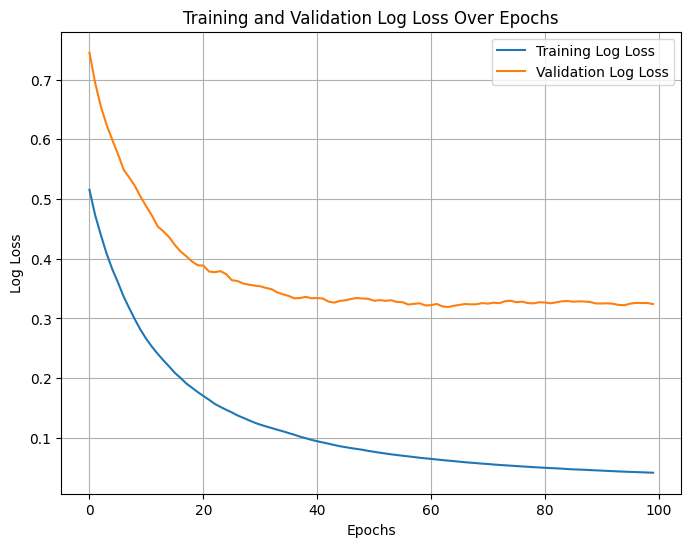


Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.88      0.90        40
         1.0       0.88      0.93      0.90        40

    accuracy                           0.90        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80


Confusion Matrix:
[[35  5]
 [ 3 37]]
True Positives (TP): 37
True Negatives (TN): 35
False Positives (FP): 5
False Negatives (FN): 3

Feature Importances:
                         Feature  Importance
10                lbp_uniformity    0.308641
11                      porosity    0.171244
0                       mean_val    0.101939
3                   kurtosis_val    0.066371
2                   skewness_val    0.062743
6                vert_coeff_mean    0.062640
1                   variance_val    0.060477
7               depth_coeff_mean    0.059422
5               horiz_coeff_mean    0.053868
9                   total_energy    0.0526

c:\Users\equipo\.conda\envs\workenvAutoencoder2\lib\site-packages\xgboost\core.py:158: UserWarning: [12:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [7]:
#Load the best weights saved from a hyperparameter grid search and fit a classification model

import json
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Read the best parameters from the text file
with open('best_params.txt', 'r') as file:
    best_params = json.load(file)

# Initialize the model with the best parameters
model2 = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    use_label_encoder=False,  # For compatibility
    tree_method='gpu_hist',  # Use GPU for training if available
    **best_params
)

# Dictionary to store training and validation metrics
evals_result = {}

# Fit the model using the training data
model2.fit(
    trainData, trainLabels,
    eval_set=[(trainData, trainLabels), (valData, valLabels)],  # Track training and validation scores
    verbose=True,  # Print training progress
)

# Extract training and validation scores
train_logloss = model2.evals_result()['validation_0']['logloss']
val_logloss = model2.evals_result()['validation_1']['logloss']

# Plot training and validation scores over epochs
plt.figure(figsize=(8, 6))
plt.plot(train_logloss, label='Training Log Loss')
plt.plot(val_logloss, label='Validation Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.savefig("texture_training_validation_logloss.png", dpi=300, bbox_inches='tight')  # Saves the figure as a PNG

# Display the plot
plt.show()

plt.show()


# Make predictions on the test set
y_pred_prob = model2.predict_proba(testData)[:, 1]  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Confusion matrix
cm = confusion_matrix(testLabels, y_pred)
tn, fp, fn, tp = cm.ravel()  # Extract TN, FP, FN, TP

# Print results
print("\nClassification Report:\n", classification_report(testLabels, y_pred))
print("\nConfusion Matrix:")
print(cm)
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Get feature importances
importances = model2.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': featureNames,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("\nFeature Importances:")
print(feature_importance_df)

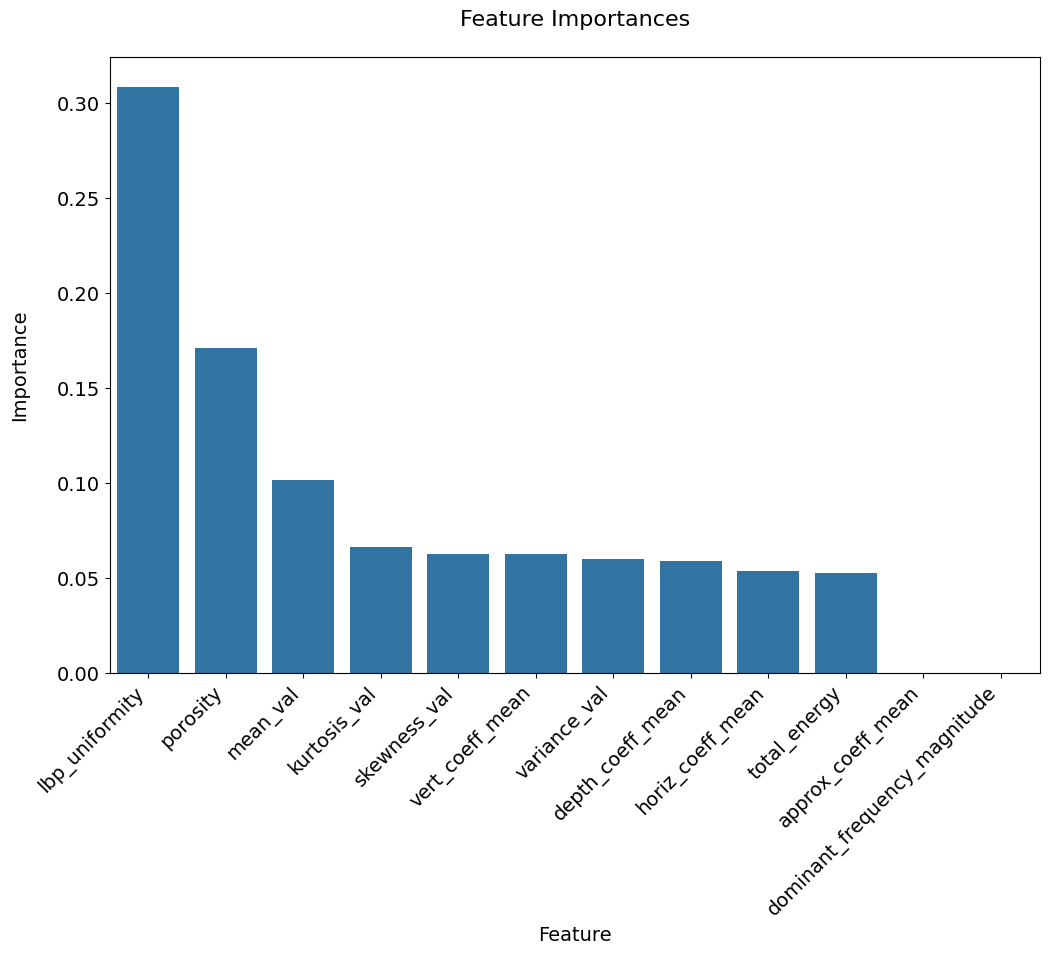

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the feature importances as a boxplot
# Plot the feature importances as a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df, order=feature_importance_df['Feature'])
plt.title('Feature Importances\n',fontsize=16)
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Importance\n',fontsize=14)
plt.xticks(rotation=45, ha='right',fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('feature_importances.png', bbox_inches='tight')
plt.show()

